In [1]:
import json
with open("/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/Corona2.json") as f:
    annotation = json.load(f)

In [2]:
TRAIN_DATA  = []
for e in annotation["examples"]:
    content = e["content"]
    entities = []
    for an in e["annotations"]:        
        if len(an["value"]) == len(an["value"].strip()):          
            if len(an['human_annotations']) == 0:
                continue
            info = (an["start"],an["end"],an["tag_name"])
            entities.append(info)
            #print(an["start"],an["end"],an["tag_name"])
    if len(entities) > 0:
        TRAIN_DATA.append(([content,{"entities":entities}]))

In [3]:
from __future__ import unicode_literals, print_function
import random
from pathlib import Path
from spacy.util import minibatch, compounding
import spacy
import sys

In [4]:
spacy.util.use_gpu(0)
def train_model(model=None, output_dir="/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/medical-ner", n_iter=1000):
    if model is not None:
        nlp = spacy.load(model)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")

    if "ner" not in nlp.pipe_names:
        ner = nlp.create_pipe("ner")
        nlp.add_pipe(ner, last=True)
    else:
        ner = nlp.get_pipe("ner")

    for _, annotations in TRAIN_DATA:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        if model is None:
            nlp.begin_training(device=0)
        for itn in range(n_iter):
            random.shuffle(TRAIN_DATA)
            losses = {}
            batches = minibatch(TRAIN_DATA, size=compounding(4.0, 64.0, 1.2))
            for batch in batches:
                texts, annotations = zip(*batch)
                nlp.update(
                    texts,  
                    annotations,  
                    drop=0.20, 
                    losses=losses
                   
                )
            print("Losses", losses)

    # save model to output directory
    if output_dir is not None:
        output_dir = Path(output_dir)
        if not output_dir.exists():
            output_dir.mkdir()
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)

In [ ]:
#!pip install transformers==2.0.0

In [6]:
train_model()

In [8]:
nlp2 = spacy.load("/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/medical-ner")

In [9]:
import numpy as np
import pandas as pd
import os
import json
import random

files = []
for dirname, _, filenames in os.walk('/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/CORD-19-research-challenge/biorxiv_medrxiv/biorxiv_medrxiv/pdf_json/'):
    for filename in filenames:
        if ".json" in filename:           
            fpath = os.path.join(dirname, filename)
            if len(files) < 300:
                files.append(fpath)
random.shuffle(files)

In [10]:
output = []
entities = []
for i in range(0,len(files)):
    if i%100 == 0:
        print('completed ', i)
    with open(files[i]) as f:
        file_data = json.load(f)        
    for o in file_data["body_text"]: 
            doc = nlp2(o["text"],disable=['parser','tagger'])
            for ent in doc.ents:
                if len(ent.text) > 2:
                    entities.append((ent.text, ent.label_))

completed  0
completed  100
completed  200


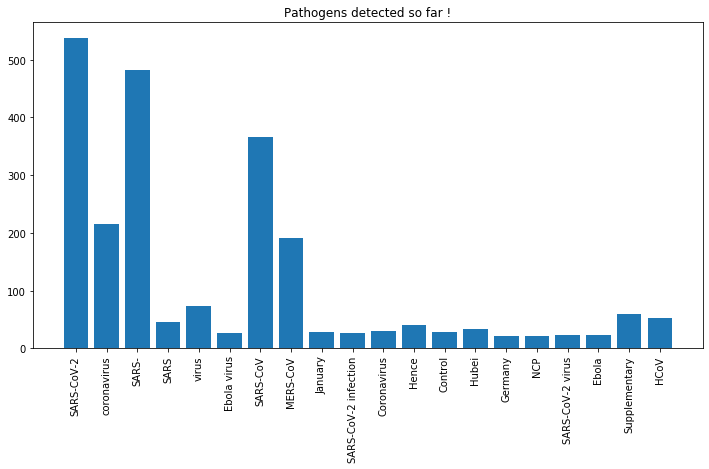

<Figure size 864x432 with 0 Axes>

In [11]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
pathogens = [l[0] for l in entities if l[1] == 'Pathogen']
counts = Counter(pathogens)
counts = {x : counts[x] for x in counts if counts[x] >= 20}
plt.title("Pathogens detected so far !")
plt.xticks(rotation='vertical')
plt.bar(counts.keys(),counts.values())
plt.show()
plt.savefig('path.png')

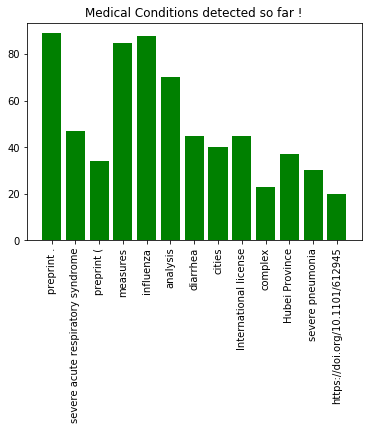

<Figure size 432x288 with 0 Axes>

In [12]:
medical_conds = [l[0] for l in entities if l[1] == 'MedicalCondition']
counts = Counter(medical_conds)
counts = {x : counts[x] for x in counts if counts[x] >=20 and len(x) > 4}
plt.xticks(rotation='vertical')
plt.title("Medical Conditions detected so far !")
plt.bar(counts.keys(),counts.values(),color ="g")
plt.show()
plt.savefig('mc.png')

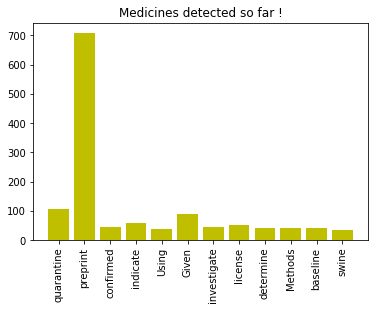

<Figure size 432x288 with 0 Axes>

In [13]:
medicines = [l[0] for l in entities if l[1] == 'Medicine']
counts = Counter(medicines)
counts = {x : counts[x] for x in counts if counts[x] >=35 and len(x) > 4}
#plt.xticks(counts.keys(),rotation='vertical')
plt.xticks(rotation='vertical')
plt.title("Medicines detected so far !")
plt.bar(counts.keys(),counts.values(),color="y")
plt.show()
plt.savefig('med.png')

In [14]:
text = "The Dutch Center of Disease control (CDC), in a public document onits website, suggested to treat severe infections requiring admission tothe hospital and oxygen therapy or admitted to the ICU with chloro-quine. However, the document also stated that treating patientsonly with optimal supportive care is still a reasonable option, due tolack of supportive evidence. The suggested regimen in adults consistsof 600 mg of chloroquine base (6 tablets A-CQ 100 mg) followed by300 mg after 12 h on day 1, then 300 mg × 2/die per os on days2–5 days. This document also underlined 1) the needs for stopping thetreatment at day 5 to reduce the risk of side effects, considering thelong half-life of the drug (30 h); 2) the need to differentiate betweenregimens based on chloroquine phosphate and chloroquine base since500 mg of thefirst correspond to 300 mg of the second [8].Another guideline document by the Italian Society of Infectious andTropical disease (Lombardy section) recommend the use of chlorochine500 mg × 2/die or hydroxychloroquine200 mg die for 10 days, althoughthe treatment may vary from 5 to 20 days according to clinical severity.The suggested target population ranged from patients with mild respi-ratory symptoms and comorbidities to patients with severe respiratory failure. In-vitro studies have suggested that chloroquine, an immunomodulantdrug traditionally used to treat malaria, is effective in reducing viral rep-lication in other infections, including the SARS-associated coronavirus(CoV) and MERS-CoV."

In [16]:
from spacy import displacy
doc = nlp2(text)
displacy.render(doc, style="ent")

# BIO-NER on CoVID19 data

In [19]:
#!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_ner_bionlp13cg_md-0.2.4.tar.gz
#!pip install scispacy

In [20]:
import scispacy
import en_ner_bionlp13cg_md
#A spaCy NER model trained on the BIONLP13CG corpus

In [25]:
import pandas as pd
df = pd.read_csv("/Users/patsnap/Desktop/Neo4J_and_other_codes/Coronavirus_19/corona.csv")

In [26]:
df.columns

Index(['cord_uid', 'sha', 'pmcid', 'title', 'abstract', 'publish_time', 'url',
       'paper_id', 'text_body', 'count_abstract', 'count_text'],
      dtype='object')

In [27]:
from spacy import displacy
from scispacy.abbreviation import AbbreviationDetector
from scispacy.umls_linking import UmlsEntityLinker

In [32]:
nlp = en_ner_bionlp13cg_md.load()

In [33]:
abstract = df.abstract[0]
doc = nlp(abstract)
displacy.render(doc,jupyter=True,style='ent')

In [35]:
displacy.render(next(doc.sents), style='dep', jupyter=True)

In [36]:
for x in doc.ents:
    print(x.text,x.label_)

wildlife ORGANISM
oral rabies CANCER
rabies ORGANISM
Dufferin SAD ORGANISM
rabies ORGANISM
rabies ORGANISM
SAD GENE_OR_GENE_PRODUCT
SAD Bernorigderived rabies ORGANISM
multiple replicationcompetent haplotypes GENE_OR_GENE_PRODUCT
ERABHK21 GENE_OR_GENE_PRODUCT
